In [1]:
# --- Importing Libraries -------------------------------------------------------
import pandas as pd
import numpy as np
import winsound
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.linear_model import LogisticRegression as LRC
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import BaggingClassifier as BAG
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from mlxtend.classifier import EnsembleVoteClassifier as EVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skopt import BayesSearchCV as BSCV
from skopt.space import Real, Categorical, Integer

# --- Matplotlib Settings -------------------------------------------------------
matplotlib.rc('figure', facecolor='k')
style.use('dark_background')

# --- Pandas Display Settings ---------------------------------------------------
pd.options.display.width = 113
pd.options.display.max_columns = 100
pd.options.display.colheader_justify='right'

# --- Importing CVSs ------------------------------------------------------------
raw = pd.read_csv('data/german_data.csv') # categoricals are phrases or words
doc = pd.read_csv('data/german_data_original.csv')# ordinals are alphanumeric codes
don = pd.read_csv('data/german_data_original_numeric.csv')# ordinals are numeric ranks

## 1. Feature Engineering: Creating New Numerical Features
---
- Minimum Salary Requirement:
    - $ MSR = Amount \times \Big( 1 + \frac{Rate}{100} \Big) \times Time $
- Total Profit: 
    - $ TPR = Amount \times \Big( \frac{Rate}{100} \Big) \times Time $
- Interaction 1: 
    - $ IN1 = Amount \times \Big( \frac{Rate}{100} \Big) $

In [2]:
# --- Creating the new features -------------------------------------------------
# MSR (Minimum Salary Requirement) units in thousands
MSR = raw['amount']*(1+(0.01*raw['inst_rate']))*raw['loan_time']*0.001
MSR.name = 'MSR'

# TPR (Total Profit)
TPR = raw['amount']*0.01*raw['inst_rate']*raw['loan_time']
TPR.name = 'TPR'

# IN1 (Interaction 1)
IN1 = raw['amount']*0.01*raw['inst_rate']
IN1.name = 'IN1'

# Displaying statistical summary
pd.options.display.float_format = '{:8.2f}'.format
print pd.concat([MSR, TPR, IN1], axis=1).describe().T

       count     mean      std      min      25%      50%      75%      max
MSR  1000.00    92.10   131.56     1.53    18.15    41.03   101.63   957.96
TPR  1000.00  2469.32  3623.67    24.04   465.69  1117.80  2824.59 33664.80
IN1  1000.00    88.70    79.48     5.00    38.64    62.28   109.75   572.72


## 2. Creating dataset, training set and hold-out set
---

In [3]:
# --- Attaching New Numerical Features and Installment Rate ---------------------
'''
[NOTE]
Installment Rate (INR) is there in the repository that this dataset was obtained 
from (raw) but that same repository has 2 other formats of the same dataset, one 
having categorical/ordinals (doc dataset) in alphanumeric format (i.e. no implied 
rankings) and the other having numerical rankings for the ordinal features (don
dataset). The numerical dataset was deemed most useful to use however it has INR 
missing (along with a few more changes)

Also... columns names have been altered after they had been downloaded from the
online public repository
'''
# Indentifying column names to use for new dataset
# Numerical features
nume = ['DUR', 'AMT', 'INR', 'RES', 'AGE', 'CRD', 'PPL'] # taken from doc dataset
# Ordinal features (encoded as rankings)
ordi = ['CHK', 'HIS', 'SAV', 'EXP', 'SEX', 'PPT', 'OIP'] # taken from don dataset
# Binary features
bina = ['TEL', 'FRN', 'car_new', 'car_used', 'deb_none', # taken from don dataset
        'deb_coap', 'rents', 'owns', 'unemp', 'unskilled', 'skilled']

# Appending features and creating new dataset
df = pd.concat([doc[nume], MSR, TPR, IN1, don[ordi], don[bina]], axis=1)
feature_names = df.columns.tolist()

# Editting Class Labels: 0 is Bad and 1 is Good
y = [1 if label == 1 else 0 for label in don['default'].values]
print '>>> Number of Good (1) in y:', sum(y)
print '>>> Number of Bad (0) in y: ', 1000-sum(y)

# Creating Training and Hold-Out Set
X_train, X_test, y_train, y_test = train_test_split(df.values, y, 
                                                    random_state = 2018)

# Printing summaries about the training and hold-out sets
print '\n>>> Train size:', len(y_train)
print '>>> Test size: ', len(y_test)
print '\n>>> -ve class in train: {} ({}%)'.format(y_train.count(0),
                                              y_train.count(0)*100/len(y_train))
print '>>> -ve class in test:  {}  ({}%)\n'.format(y_test.count(0),
                                             y_test.count(0)*100/len(y_test))
print '>>> First 6 records of the new dataset'
pd.options.display.float_format = '{:8.6g}'.format
print df.head(6).T
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

>>> Number of Good (1) in y: 700
>>> Number of Bad (0) in y:  300

>>> Train size: 750
>>> Test size:  250

>>> -ve class in train: 218 (29%)
>>> -ve class in test:  82  (32%)

>>> First 6 records of the new dataset
                 0        1        2        3        4        5
DUR              6       48       12       42       24       36
AMT           1169     5951     2096     7882     4870     9055
INR              4        2        2        2        3        2
RES              4        2        3        4        4        4
AGE             67       22       49       45       53       35
CRD              2        1        1        1        2        1
PPL              1        1        2        2        2        2
MSR        7.29456  291.361   25.655  337.665  120.386    332.5
TPR         280.56  5712.96   503.04  6620.88   3506.4   6519.6
IN1          46.76   119.02    41.92   157.64    146.1    181.1
CHK              1        2        4        1        1        4
HIS             

## 3. Recursive Feature Elimination (Attempt)
---
Investigating the effect of reducing features on accruacy and cost with a Random Forest Classifier. The classifier is first tuned with Bayesian Search, convergence results are then plotted and then the actual RFC is conducted.

In [4]:
# --- Defining Custom Cost Function ---------------------------------------------******************************
def custom_cost_function(y_true, y_pred):
    '''
    [Description]
    -----------------------------------------------------------------------------
    As per requirements of the dataset documentation, the model should penalise
    false positives (incorrectly identified credible cases) as five times worse
    than false negatives. This function calculates this custom cost function for
    implementation with the sklearn metrics package. Cost function value is
    negated as per conventions of the metrics package.
    '''
    
    score = 0
    for i, pred in enumerate(y_pred):
        
        # False Negative
        if pred == 0 and y_true[i] == 1:
            score = score - 1
        
        # False Positive
        elif pred == 1 and y_true[i] == 0:
            score = score - 5
    
    return score

# --- Modes ---------------------------------------------------------------------
cost_function = metrics.make_scorer(custom_cost_function)
mode = 'score_by_custom_cost_function'; scoring = cost_function
#mode = 'score_by_roc_auc'; scoring = 'roc_auc'

# --- Declaring Hyperparameters for the Random Forest Classifier ----------------
params = {'n_estimators': Integer(1, 100),
          'criterion': Categorical(['gini','entropy']),
          'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
          'max_depth': Integer(1, 10),
          'bootstrap': Categorical([True, False]),
          'random_state': Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

# --- Bayesian Search with embedded k-fold cross-validation ---------------------
folds = 3
iterations = 20
DT_rfc = RFC(class_weight='balanced', n_jobs=-1) # Random Forest Classifier
hps = BSCV(DT_rfc, params, cv=folds, n_iter=iterations, scoring=scoring, 
           iid=True, return_train_score=False, random_state=2018)
hps.fit(X_train, y_train)
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

# --- Formating and Displaying Hyperparamter Search Results ---------------------
res = pd.DataFrame(hps.cv_results_)
a = res[['mean_test_score', 'std_test_score']]
res.drop(['mean_test_score', 'std_test_score', 'params', 'mean_fit_time', 
          'mean_score_time', 'std_fit_time', 'std_score_time', 
          'rank_test_score'], axis=1, inplace=True)
if mode == 'score_by_custom_cost_function':
    total_loss = res.loc[:, 'split0_test_score']
    for i in range(1, folds):
        total_loss = total_loss + res.loc[:, 'split{}_test_score'.format(i)]
    total_loss.name = 'total_loss'
    res = pd.concat([total_loss, a, res], axis=1)
    res.sort_values(by=['total_loss'], inplace=True, ascending=False)
else:
    res = pd.concat([a, res], axis=1)
    res.sort_values(by=['mean_test_score'], inplace=True, ascending=False)
pd.options.display.float_format = '{:.4g}'.format
print '>>> Bayesian Hyperparameter Search top 5 results:'
print res.head(5).T

# --- Feature Importance Results ------------------------------------------------
print '\n>>> Feature importances of best found classifier:'
feature_importances = pd.DataFrame(data=hps.best_estimator_.feature_importances_,
                                   index=feature_names, columns=['impt'])
pd.options.display.float_format = '{:.2g}'.format
print '\n', feature_importances.T

# --- Hold-Out Set Performance --------------------------------------------------
y_pred = hps.best_estimator_.predict(X_test)
pd.options.display.float_format = '{:.4g}'.format
print '\n>>> Hold-Out Set Performance:' 
print pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                   columns = ['Pred Bad', 'Pred Good'],
                   index = ['Actual Bad', 'Actual Good'])
print '\nHold-Out Set Loss:', custom_cost_function(y_test, y_pred)
print 'Hold-Out Set Accuracy:', metrics.accuracy_score(y_test, y_pred)

C:\Users\Armin\Anaconda2\lib\site-packages\skopt\optimizer\optimizer.py:369: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>>> Bayesian Hyperparameter Search top 5 results:
                                     19       12       13       17       2 
total_loss                         -461     -461     -473     -475     -476
mean_test_score                  -153.7   -153.7   -157.7   -158.4   -158.7
std_test_score                    18.56    18.56    15.19    16.37    21.77
param_bootstrap                   False    False    False     True     True
param_criterion                 entropy  entropy  entropy  entropy  entropy
param_max_depth                       5        5        4        5        3
param_min_weight_fraction_leaf     0.03     0.03     0.03     0.01     0.01
param_n_estimators                   69       69       69       28       33
param_random_state                   25       25       25     2018     2018
split0_test_score                  -178     -178     -179     -181     -188
split1_test_score                  -150     -150     -149     -151     -136
split2_test_score                  -13

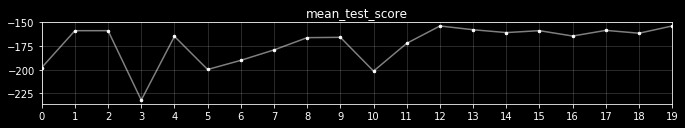

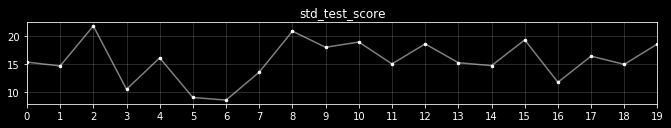

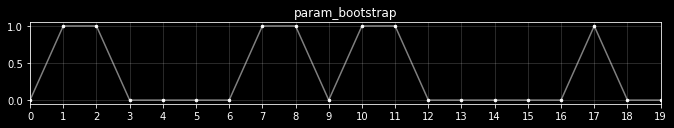

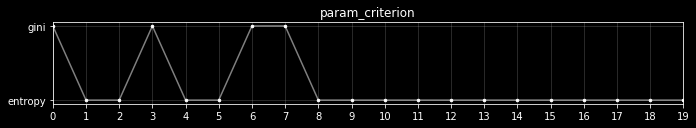

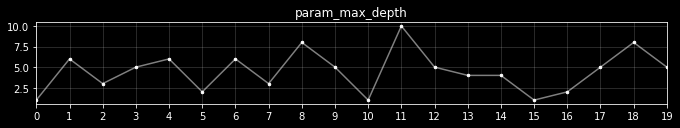

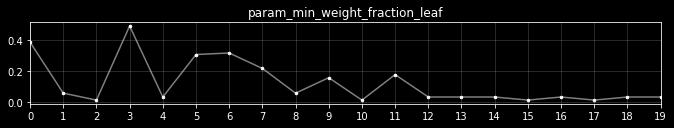

In [5]:
# --- Bayesian Search Convergence Plots -----------------------------------------
res.sort_index(inplace=True)
for col in res.iloc[:,1:-5].columns.values:
    fig = plt.figure(figsize=[11.3, 1.5])
    plt.plot(res.index.values, res[col].values, '.', color='w', markersize=5)
    plt.plot(res.index.values, res[col].values, '-', color='w', alpha=0.5)
    plt.title(col)
    plt.xlim([0, iterations-1])
    plt.xticks(range(0, iterations))
    plt.grid(True, alpha=0.2)
    plt.show()

In [6]:
# --- Recursive Feature Elimination ---------------------------------------------******************************
pd.options.display.float_format = '{:.3g}'.format

for n_features in range(1, len(feature_names)+1):
    
    # Setting up the selector
    selector = RFE(hps.best_estimator_, n_features_to_select=n_features)
    
    # Fitting selector
    selector = selector.fit(X_train, y_train)
    
    # Harvesting selected feature rankings
    rank = pd.Series(data=selector.ranking_, name='cost', index=feature_names)
    
    # Masks will be used to find the selected features and create the hold-set
    masks = [0 if mask==False else 1 for mask in selector.support_.tolist()]
    masks = pd.Series(data=masks, name='accu', index=feature_names)
    
    # Results dataframe
    res = pd.concat([rank, masks], axis=1).sort_values(['cost'])
    res['cost'] = res.index.values
    res.reset_index(inplace=True, drop=True)
    res = res.T
    
    # Finding selected features with mask values
    cols = []
    for j in res.columns:
        if res.loc['accu', j] == 1:
            cols.append(res.loc['cost', j])
        else:
            res.loc['cost', j] = '-'
            
    # Creating the new hold-out set with only the selected features
    X_tr, X_te, y_tr, y_te = train_test_split(df[cols].values, y, 
                                              random_state=2018)
    '''
    [Note] Different set names have been used so that they do not replace the
           original training and hold-sets that were created earlier
    '''
    # Training RFC with only the selected features
    model = hps.best_estimator_.fit(X_tr, y_tr)
    
    # Getting predictions
    y_pr = model.predict(X_te)
    
    # Computing hold-out set cost and accuracy
    cost = custom_cost_function(y_te, y_pr)
    accu = metrics.accuracy_score(y_te, y_pr)
    
    # Attaching hold-out set results to results dataframe
    test = pd.DataFrame(data=[cost, accu], index=['cost', 'accu'], 
                        columns=['TEST'])
    print pd.concat([test, res], axis=1)
    print

      TEST    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cost  -170  CHK  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
accu 0.608    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

      TEST    0    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cost  -213  CHK  TPR  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
accu 0.628    1    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

      TEST    0    1    2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cost  -232  CHK  MSR  TPR  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
accu   0.6    1    1    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

      TEST    0    1    2    3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cos

      TEST    0     1      2         3         4        5    6    7    8    9   10   11   12   13   14   15  \
cost  -190  DUR  owns  rents  deb_none  car_used  car_new  TEL  OIP  PPT  SEX  SAV  EXP  CHK  IN1  TPR  MSR   
accu 0.688    1     1      1         1         1        1    1    1    1    1    1    1    1    1    1    1   

       16   17   18   19   20   21       22 23 24 25 26 27  
cost  CRD  AGE  RES  INR  AMT  HIS  skilled  -  -  -  -  -  
accu    1    1    1    1    1    1        1  0  0  0  0  0  

      TEST    0     1      2         3         4        5    6    7    8    9         10   11   12   13   14  \
cost  -188  DUR  owns  rents  deb_none  car_used  car_new  TEL  OIP  PPT  SEX  unskilled  SAV  EXP  CHK  IN1   
accu 0.664    1     1      1         1         1        1    1    1    1    1          1    1    1    1    1   

       15   16   17   18   19   20   21   22       23 24 25 26 27  
cost  TPR  MSR  CRD  AGE  RES  INR  AMT  HIS  skilled  -  -  -  -  
accu    1

### Conclusion: hold-out set performance cannot be improved with feature elimination

## 4. Custom Datasets (Attempt)
---
Some of the numerical features are using the same original numerical features (AMR, INR, DUR) so here we test to see if not including the duplicated pieces of information about a record will yield better hold-out set performance:
- Set 1: AMT, DUR, INR, TPR, IN1 Removed MSR and everything else stays
- Set 2: AMT, DUR, INR, MPR, IN1 Removed TPR and everything else stays
- Set 2: AMT, INR, MSR, TPR Removed IN1 and everything else stays (DUR not removed as IN1 does not use it)
- Set 2: No new numerical features (MSR, TPR and IN1 removed)

In [7]:
# --- Testing Routine (HPS and the Hold-Out set scores) -------------------------******************************
def CUSTOM_DF_TEST(cdf):
    '''
    [Description]
    -----------------------------------------------------------------------------
    1. Creates new training and hold-out sets
    2. Conducts Bayesian Hyperparameter Search with new custom dataset
    3. Prints feature importances
    4. Prints hold-out set performance
    
    [Inputs]
    -----------------------------------------------------------------------------
    _________
    custom_df|   [pandas DataFrame]
                 The custom dataframe
                 
    [Outputs]
    -----------------------------------------------------------------------------
    _________
    *list*   |   [list]
                 Contains:
                 - the fitted Bayesian hyperparameter search object
                 - the modified hyperparameter search results dataframe
                 - feature importance dataframe
    '''
    
    # --- Creatign New Training and hold-out sets -------------------------------
    cfeature_names = cdf.columns.tolist()
    X_tr, X_te, y_tr, y_te = train_test_split(cdf.values, y, random_state = 2018)
    
     # --- Bayesian Hyperparameter Search ---------------------------------------
    chps = BSCV(DT_rfc, params, cv=folds, n_iter=iterations, scoring=scoring,
                iid=True, return_train_score=False, random_state=2018)
    chps.fit(X_tr, y_tr)
    winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

    # --- Formating Hyperparameter Search Results -------------------------------
    cres = pd.DataFrame(chps.cv_results_)
    a = cres[['mean_test_score', 'std_test_score']]
    cres.drop(['mean_test_score', 'std_test_score', 'params', 'mean_fit_time', 
               'mean_score_time', 'std_fit_time', 'std_score_time', 
               'rank_test_score'], axis=1, inplace=True)
    total_cost = cres.loc[:, 'split0_test_score']
    for i in range(1, folds):
        total_cost = total_cost + cres.loc[:, 'split{}_test_score'.format(i)]
    total_cost.name = 'total_cost'
    cres = pd.concat([total_cost, a, cres], axis=1)
    cres.sort_values(by=['total_cost'], inplace=True, ascending=False)

    # --- Feature Importance Results --------------------------------------------
    cfeature_imps = pd.DataFrame(data=chps.best_estimator_.feature_importances_,
                                 index=cfeature_names, columns=['impt'])
    pd.options.display.float_format = '{:.2g}'.format
    print cfeature_imps.T

    # --- Hold-Out Set Performance ----------------------------------------------
    y_pr = chps.best_estimator_.predict(X_te)
    pd.options.display.float_format = '{:.4g}'.format
    print '\n', pd.DataFrame(metrics.confusion_matrix(y_te, y_pr),
                             columns = ['Pred Bad', 'Pred Good'],
                             index = ['Actual Bad', 'Actual Good'])
    print '\nHold-Out Set Loss:', custom_cost_function(y_te, y_pr)
    print 'Hold-Out Set Accuracy:', metrics.accuracy_score(y_te, y_pr)
    return [chps, cres, cfeature_imps]

# --- MSR in & AMT, DUR, INR, TPR and IN1 out -----------------------------------
cdf = df.drop(['AMT', 'DUR', 'INR', 'TPR', 'IN1'], axis=1)
print '>>> M S R ----------------------------------------------------------------'
kMSR = CUSTOM_DF_TEST(cdf)

# --- TPR in & AMT, DUR, INR, MSR and IN1 out -----------------------------------
cdf = df.drop(['AMT', 'DUR', 'INR', 'MSR', 'IN1'], axis=1)
print '>>> T P R ----------------------------------------------------------------'
kTPR = CUSTOM_DF_TEST(cdf)

# --- IN1 & DUR in & AMT, INR, MSR and TPR out ----------------------------------
cdf = df.drop(['AMT', 'INR', 'MSR', 'TPR'], axis=1)
print '>>> I N 1 ----------------------------------------------------------------'
kIN1 = CUSTOM_DF_TEST(cdf)

# --- MSR, TPR and IN1 out ------------------------------------------------------
cdf = df.drop(['IN1', 'MSR', 'TPR'], axis=1)
print '>>> N O   N E W   N U M E R I C A L   I N T E R A C T I O N S  -----------'
defu = CUSTOM_DF_TEST(cdf)

>>> M S R ----------------------------------------------------------------
      RES   AGE   CRD  PPL  MSR  CHK   HIS  SAV   EXP   SEX  PPT   OIP  TEL  FRN  car_new  car_used  deb_none  \
impt    0 0.068 0.014    0 0.15 0.16 0.055 0.16 0.027 0.014 0.12 0.082    0    0    0.041     0.014     0.014   

      deb_coap  rents  owns  unemp  unskilled  skilled  
impt         0      0 0.068      0          0        0  

             Pred Bad  Pred Good
Actual Bad         59         23
Actual Good        68        100

Hold-Out Set Loss: -183
Hold-Out Set Accuracy: 0.636
>>> T P R ----------------------------------------------------------------
        RES   AGE   CRD    PPL  TPR  CHK   HIS  SAV   EXP   SEX   PPT  OIP    TEL    FRN  car_new  car_used  \
impt 0.0075 0.043 0.014 0.0054  0.2  0.3 0.047 0.11 0.044 0.023 0.051 0.04 0.0023 0.0077    0.027     0.031   

      deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
impt     0.004    0.0017  0.009 0.019 0.0013     0.0071   0.0014 

### Conclusion: None of the custom datasets are improving the hold-out accraucy either

## 5. Preprocessing: Scaling features
---
Logistic Regression and Support Vector classifiers requrie a scaled dataset

In [8]:
# Unscaled data
pd.options.display.float_format = '{:5.2f}'.format
print df.describe().iloc[[1,2,3,7],:], '\n'

       DUR      AMT   INR   RES   AGE   CRD   PPL    MSR      TPR    IN1   CHK   HIS   SAV   EXP   SEX   PPT  \
mean 20.90  3271.26  2.97  2.85 35.55  1.41  1.16  92.10  2469.32  88.70  2.58  2.54  2.10  3.38  2.68  2.36   
std  12.06  2822.74  1.12  1.10 11.38  0.58  0.36 131.56  3623.67  79.48  1.26  1.08  1.58  1.21  0.71  1.05   
min   4.00   250.00  1.00  1.00 19.00  1.00  1.00   1.53    24.04   5.00  1.00  0.00  1.00  1.00  1.00  1.00   
max  72.00 18424.00  4.00  4.00 75.00  4.00  2.00 957.96 33664.80 572.72  4.00  4.00  5.00  5.00  4.00  4.00   

       OIP   TEL   FRN  car_new  car_used  deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
mean  2.67  1.40  1.04     0.23      0.10      0.91      0.04   0.18  0.71   0.02       0.20     0.63  
std   0.71  0.49  0.19     0.42      0.30      0.29      0.20   0.38  0.45   0.15       0.40     0.48  
min   1.00  1.00  1.00     0.00      0.00      0.00      0.00   0.00  0.00   0.00       0.00     0.00  
max   3.00  2.00  2.00 

In [9]:
print '>>> MinMax ---------------------------------------------------------------'
X_minmax = MinMaxScaler().fit_transform(df.values)
df_minmax = pd.DataFrame(data=X_minmax, columns=df.columns)
print df_minmax.describe().iloc[[1,2,3,7],:], '\n'

>>> MinMax ---------------------------------------------------------------
       DUR   AMT   INR   RES   AGE   CRD   PPL   MSR   TPR   IN1   CHK   HIS   SAV   EXP   SEX   PPT   OIP  \
mean  0.25  0.17  0.66  0.62  0.30  0.14  0.15  0.09  0.07  0.15  0.53  0.64  0.28  0.60  0.56  0.45  0.84   
std   0.18  0.16  0.37  0.37  0.20  0.19  0.36  0.14  0.11  0.14  0.42  0.27  0.40  0.30  0.24  0.35  0.35   
min   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
max   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   

       TEL   FRN  car_new  car_used  deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
mean  0.40  0.04     0.23      0.10      0.91      0.04   0.18  0.71   0.02       0.20     0.63  
std   0.49  0.19     0.42      0.30      0.29      0.20   0.38  0.45   0.15       0.40     0.48  
min   0.00  0.00     0.00      0.00      0.00      0.00   0.00  0.00   0.00     

In [10]:
print '>>> StandardScaler -------------------------------------------------------'
X_normalized = StandardScaler().fit_transform(df.values)
df_normalized = pd.DataFrame(data=X_normalized, columns=df.columns)
print df_normalized.describe().iloc[[1,2,3,7],:], '\n'

>>> StandardScaler -------------------------------------------------------
       DUR   AMT   INR   RES   AGE   CRD   PPL   MSR   TPR   IN1   CHK   HIS   SAV   EXP   SEX   PPT   OIP  \
mean  0.00  0.00  0.00 -0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00 -0.00  0.00   
std   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   
min  -1.40 -1.07 -1.76 -1.67 -1.46 -0.70 -0.43 -0.69 -0.68 -1.05 -1.25 -2.35 -0.70 -1.97 -2.38 -1.29 -2.38   
max   4.24  5.37  0.92  1.05  3.47  4.49  2.33  6.59  8.61  6.09  1.13  1.34  1.83  1.34  1.86  1.56  0.46   

       TEL   FRN  car_new  car_used  deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
mean -0.00  0.00     0.00      0.00      0.00      0.00   0.00  0.00  -0.00      -0.00    -0.00  
std   1.00  1.00     1.00      1.00      1.00      1.00   1.00  1.00   1.00       1.00     1.00  
min  -0.82 -0.20    -0.55     -0.34     -3.12     -0.21  -0.47 -1.58  -0.15     

In [11]:
# --- Creating Ordinal Dictionaries (for later reference) -----------------------
ordinals = ('CHK', 'HIS', 'SAV', 'EXP', 'SEX', 'PPT', 'OIP')
ordi_dicts = {}
for col in ordinals:
    index = doc[col].value_counts().index.tolist()
    a = df[col].value_counts().index.tolist()
    b = df_minmax[col].value_counts().index.tolist()
    c = df_normalized[col].value_counts().index.tolist()
    d = df[col].value_counts().values.tolist()
    dict_i = pd.DataFrame({col+'_rank': a, 'minmax': b, 'normalized':c, 'count': d})
    dict_i.index = index
    dict_i = dict_i[[col+'_rank', 'minmax', 'normalized', 'count']]
    dict_i.sort_values(col+'_rank', inplace=True)
    ordi_dicts[col] = dict_i
    
# Sample dictionary
print ">>> Sample Dictionary {'CHK'}"
print ordi_dicts['CHK']

# --- Pickling ------------------------------------------------------------------
# with open('pickles/feature_names.pkl','wb') as my_file:
#     pickle.dump(feature_names, my_file)

# with open('pickles/ordinal_dicts.pkl','wb') as my_file:
#     pickle.dump(ordi_dicts, my_file)
    
# with open('pickles/unscaled_dataset.pkl','wb') as my_file:
#     pickle.dump(df.values, my_file)

# with open('pickles/normalized_dataset.pkl','wb') as my_file:
#     X_normalized = StandardScaler().fit_transform(df.values)
#     pickle.dump(X_normalized, my_file)

# with open('pickles/minmax_dataset.pkl','wb') as my_file:
#     X_minmax = MinMaxScaler().fit_transform(df.values)
#     pickle.dump(X_minmax, my_file)

>>> Sample Dictionary {'CHK'}
     CHK_rank  minmax  normalized  count
A11         1    0.00       -1.25    274
A12         2    0.33       -0.46    269
A13         3    0.67        0.34     63
A14         4    1.00        1.13    394


## 6. Tuning Classifiers
---
- Part 1: Creating the routine that tunes the classifiers and tests the tuned calssifier with hold-outset and generates the performance metrics
- Part 2: Declaring the hyperparameters for each type of classifier
- Parts 3 to 6: Tuning Logistic Regression and Support Vector classifiers with Normalized dataset
- Parts 7 to 10: Tuning Logistic Regression and Support Vector classifiers with MinMax dataset
- Parts 10 to 13: Turning Decision Tree, Gradient Boosting, Random Forests and Extremely Randomized Tress with Unscaled dataset
- Part 14: Pickling results

In [12]:
# --- Defining routine (Hyperparameter Search and Hold-Out set test) ------------
def RUN_HPS(X, y, clf, param, iters, name, folds=3, mode='custom', sam_wei=None):
    '''
    [Description]
    -----------------------------------------------------------------------------
    Runs Bayesian Hyperparameter Search (HPS) to tune the selected classifiers.
    
    [Inputs]
    -----------------------------------------------------------------------------
    ________
    X       |   [list]
                Features
    ________
    y       |   [list]
                Labels
    ________
    clf     |   [sklearn classifier object]
                The classifier object that is to be tuned and test
    ________
    param   |   [dictionary]
                Hyperparameters to tune
    ________
    iters   |   [integer]
                Number of iterations allocated for the Bayesian Search
    ________
    name    |   [string]
                Name of the classifier
    ________
    folds   |   [integer] Default = 3
                Number of folds for cross-validation
    ________
    mode    |   [string] Default = 'custom'
                The metric for which the Bayesian Hyperparameter search will
                tune to optimize. Either 'custom' (custom cost function) or
                'roc_auc'
    ________
    sam_wei |   [list] Default = None
                Sample weights. Some sklearn classifiers do not have a
                class_weight parameter however they all do have sample_weights.
                If specified, sample weights will be fed into the Bayesian Search
                
    [Outputs]
    -----------------------------------------------------------------------------
    ____________
    *estimator* |   [fitted sklearn classifier object]
                    The tuned classifier that the Bayesian Hyperparameter Search
                    has produced
    ____________
    cm          |   [pandas Series]
                    Contains confusion matrix elements in this order:
                    - False Positive
                    - False Negative
                    - True Positive
                    - True Negative
                    Name of the series is the name passed into the funciton
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018)
    
    if mode == 'custom':
        func = cost_function
    elif mode == 'roc_auc':
        func = 'roc_auc'
        
    # Bayesian hyperparameter search
    if sam_wei == None:
        hps = BSCV(clf, param, cv=folds, n_iter=iters, scoring=func, iid=True, 
                   return_train_score=False, random_state=2018)
        hps.fit(X_train, y_train)
    else:
        hps = BSCV(clf, param, cv=folds, n_iter=iters, scoring=func, iid=True, 
                   return_train_score=False, random_state=2018, 
                   fit_params=sam_wei)
        hps.fit(X_train, y_train)
    winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)
    
    # Hold-Out set performance metrics
    y_pred = hps.best_estimator_.predict(X_test)
    COST = custom_cost_function(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    
    # Hold-out set confusion matrix
    cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                      columns = ['Pred Bad', 'Pred Good'],
                      index = ['Actual Bad', 'Actual Good'])
    TN = cm.loc['Actual Bad', 'Pred Bad']
    FP = cm.loc['Actual Bad', 'Pred Good']
    TP = cm.loc['Actual Good', 'Pred Good']
    FN = cm.loc['Actual Good', 'Pred Bad']
    cm = pd.Series(data={'FP':FP, 'FN':FN, 'TP':TP, 'TN':TN}, name=name)
    print '{} |{:4g} |{:4g} |{:4g} |{:4g} |{:6g}  |{:7.3f}  |'.format(name, FP, 
                                                                      FN, TP, TN,
                                                                      COST, ACC)
    return hps.best_estimator_, cm

In [13]:
# --- Defining Hyperparameters for each classifier ------------------------------
cs = 100 # cache_size

# Declaring Hyperparameters for every type of classifier
parSL = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'fit_intercept': Categorical([True, False])}
parSX = {'gamma': Real(1e-6, 1e+6, prior='log-uniform'),
         'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'shrinking': Categorical([True, False])}
parLR = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'fit_intercept': Categorical([True, False])}
parDT = {'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
         'max_depth': Integer(1, 10)}
parGB = {'learning_rate': Categorical(np.arange(0.0, 1.0005, 0.0005)),
         'n_estimators': Integer(1, 100),
         'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
         'max_depth': Integer(1, 10)}
parRA = {'random_state': Categorical([5482, 46, 77, 2017, 2018, 25, 4]),
         'n_estimators': Integer(1, 100),
         'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
         'max_depth': Integer(1, 10)}

In [14]:
# --- Normalized dataset: Balanced Class Weights and Tuning for minimal cost ----

# Settings
cw = 'balanced' # class_weight
X = StandardScaler().fit_transform(df.values)
BE_bal_n = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_n = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_bal_n = BE_bal_n.set_value(names[i], model)
    CM_bal_n = CM_bal_n.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_bal_n = BE_bal_n.set_value(names[i], model)
    CM_bal_n = CM_bal_n.append(matrix)

# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_bal_n = BE_bal_n.set_value(names[i], model)
    CM_bal_n = CM_bal_n.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  20 |  64 | 104 |  62 |  -164  |  0.664  |
SL_l2s_n |  20 |  63 | 105 |  62 |  -163  |  0.668  |
SL_l2h_n |  18 |  64 | 104 |  64 |  -154  |  0.672  |
SX_po2_n |  38 |  62 | 106 |  44 |  -252  |  0.600  |
SX_po3_n |  36 |  33 | 135 |  46 |  -213  |  0.724  |
SX_rbf_n |  25 |  52 | 116 |  57 |  -177  |  0.692  |
SX_sig_n |  25 |  53 | 115 |  57 |  -178  |  0.688  |


C:\Users\Armin\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:332: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LR_l1s_n |  19 |  62 | 106 |  63 |  -157  |  0.676  |


C:\Users\Armin\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LR_l1l_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_l2s_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_l2l_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_nwt_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_lbf_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_sag_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |


In [15]:
# --- Normalized dataset: Imbalanced Class Weights and Tuning for minimal cost --

# Settings
cw = None # class_weight
X = StandardScaler().fit_transform(df.values)
BE_imb_n = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_n = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_imb_n = BE_imb_n.set_value(names[i], model)
    CM_imb_n = CM_imb_n.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_imb_n = BE_imb_n.set_value(names[i], model)
    CM_imb_n = CM_imb_n.append(matrix)

# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_imb_n = BE_imb_n.set_value(names[i], model)
    CM_imb_n = CM_imb_n.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  22 |  64 | 104 |  60 |  -174  |  0.656  |
SL_l2s_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
SL_l2h_n |  20 |  64 | 104 |  62 |  -164  |  0.664  |
SX_po2_n |  42 |  44 | 124 |  40 |  -254  |  0.656  |
SX_po3_n |  43 |  40 | 128 |  39 |  -255  |  0.668  |
SX_rbf_n |  40 |  39 | 129 |  42 |  -239  |  0.684  |
SX_sig_n |  43 |  17 | 151 |  39 |  -232  |  0.760  |
LR_l1s_n |  19 |  60 | 108 |  63 |  -155  |  0.684  |
LR_l1l_n |  22 |  66 | 102 |  60 |  -176  |  0.648  |
LR_l2s_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_l2l_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_nwt_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_lbf_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_sag_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |


In [16]:
# --- Normalized dataset: Balanced Class Weights and Tuning for roc_auc score ---

# Settings
cw = 'balanced' # class_weight
X = StandardScaler().fit_transform(df.values)
BE_bal_n_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_n_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_bal_n_roc = BE_bal_n_roc.set_value(names[i], model)
    CM_bal_n_roc = CM_bal_n_roc.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_bal_n_roc = BE_bal_n_roc.set_value(names[i], model)
    CM_bal_n_roc = CM_bal_n_roc.append(matrix)

# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_bal_n_roc = BE_bal_n_roc.set_value(names[i], model)
    CM_bal_n_roc = CM_bal_n_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  21 |  61 | 107 |  61 |  -166  |  0.672  |
SL_l2s_n |  22 |  57 | 111 |  60 |  -167  |  0.684  |
SL_l2h_n |  26 |  53 | 115 |  56 |  -183  |  0.684  |
SX_po2_n |  39 |  51 | 117 |  43 |  -246  |  0.640  |
SX_po3_n |  39 |  35 | 133 |  43 |  -230  |  0.704  |
SX_rbf_n |  26 |  53 | 115 |  56 |  -183  |  0.684  |
SX_sig_n |  25 |  54 | 114 |  57 |  -179  |  0.684  |
LR_l1s_n |  27 |  47 | 121 |  55 |  -182  |  0.704  |
LR_l1l_n |  26 |  48 | 120 |  56 |  -178  |  0.704  |
LR_l2s_n |  26 |  44 | 124 |  56 |  -174  |  0.720  |
LR_l2l_n |  21 |  57 | 111 |  61 |  -162  |  0.688  |
LR_nwt_n |  26 |  45 | 123 |  56 |  -175  |  0.716  |
LR_lbf_n |  26 |  45 | 123 |  56 |  -175  |  0.716  |
LR_sag_n |  26 |  44 | 124 |  56 |  -174  |  0.720  |


In [17]:
# --- Normalized dataset: Imbalanced Class Weights and Tuning for roc_auc score -

# Settings
cw = None # class_weight
X = StandardScaler().fit_transform(df.values)
BE_imb_n_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_n_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_imb_n_roc = BE_imb_n_roc.set_value(names[i], model)
    CM_imb_n_roc = CM_imb_n_roc.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_imb_n_roc = BE_imb_n_roc.set_value(names[i], model)
    CM_imb_n_roc = CM_imb_n_roc.append(matrix)

# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_imb_n_roc = BE_imb_n_roc.set_value(names[i], model)
    CM_imb_n_roc = CM_imb_n_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  41 |  20 | 148 |  41 |  -225  |  0.756  |
SL_l2s_n |  38 |  22 | 146 |  44 |  -212  |  0.760  |
SL_l2h_n |  20 |  65 | 103 |  62 |  -165  |  0.660  |
SX_po2_n |  54 |  16 | 152 |  28 |  -286  |  0.720  |
SX_po3_n |  46 |  24 | 144 |  36 |  -254  |  0.720  |
SX_rbf_n |  78 |   1 | 167 |   4 |  -391  |  0.684  |
SX_sig_n |  82 |   0 | 168 |   0 |  -410  |  0.672  |
LR_l1s_n |  45 |  20 | 148 |  37 |  -245  |  0.740  |
LR_l1l_n |  43 |  22 | 146 |  39 |  -237  |  0.740  |
LR_l2s_n |  43 |  19 | 149 |  39 |  -234  |  0.752  |
LR_l2l_n |  39 |  23 | 145 |  43 |  -218  |  0.752  |
LR_nwt_n |  49 |  16 | 152 |  33 |  -261  |  0.740  |
LR_lbf_n |  49 |  17 | 151 |  33 |  -262  |  0.736  |
LR_sag_n |  48 |  18 | 150 |  34 |  -258  |  0.736  |


In [18]:
# --- MinMax dataset: Balanced Class Weights and Tuning for minimal cost --------

# Settings
cw = 'balanced' # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_bal_m = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_m = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_bal_m = BE_bal_m.set_value(names[i], model)
    CM_bal_m = CM_bal_m.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_bal_m = BE_bal_m.set_value(names[i], model)
    CM_bal_m = CM_bal_m.append(matrix)
    
# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_bal_m = BE_bal_m.set_value(names[i], model)
    CM_bal_m = CM_bal_m.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |  25 |  48 | 120 |  57 |  -173  |  0.708  |
SL_l2s_m |  26 |  53 | 115 |  56 |  -183  |  0.684  |
SL_l2h_m |  28 |  53 | 115 |  54 |  -193  |  0.676  |
SX_po2_m |  19 |  72 |  96 |  63 |  -167  |  0.636  |
SX_po3_m |  19 |  73 |  95 |  63 |  -168  |  0.632  |
SX_rbf_m |  23 |  52 | 116 |  59 |  -167  |  0.700  |
SX_sig_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_l1s_m |  27 |  47 | 121 |  55 |  -182  |  0.704  |
LR_l1l_m |  26 |  48 | 120 |  56 |  -178  |  0.704  |
LR_l2s_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |
LR_l2l_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |
LR_nwt_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_lbf_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_sag_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |


In [19]:
# --- MinMax dataset: Imbalanced Class Weights and Tuning for minimal cost ------

# Settings
cw = None # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_imb_m = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_m = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_imb_m = BE_imb_m.set_value(names[i], model)
    CM_imb_m = CM_imb_m.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_imb_m = BE_imb_m.set_value(names[i], model)
    CM_imb_m = CM_imb_m.append(matrix)
    
# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_imb_m = BE_imb_m.set_value(names[i], model)
    CM_imb_m = CM_imb_m.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |   0 | 168 |   0 |  82 |  -168  |  0.328  |
SL_l2s_m |  39 |  23 | 145 |  43 |  -218  |  0.752  |
SL_l2h_m |  40 |  25 | 143 |  42 |  -225  |  0.740  |
SX_po2_m |  33 |  34 | 134 |  49 |  -199  |  0.732  |
SX_po3_m |  38 |  29 | 139 |  44 |  -219  |  0.732  |
SX_rbf_m |  42 |  27 | 141 |  40 |  -237  |  0.724  |
SX_sig_m |  37 |  26 | 142 |  45 |  -211  |  0.748  |
LR_l1s_m |   0 | 168 |   0 |  82 |  -168  |  0.328  |
LR_l1l_m |   0 | 168 |   0 |  82 |  -168  |  0.328  |
LR_l2s_m |  41 |  24 | 144 |  41 |  -229  |  0.740  |
LR_l2l_m |  41 |  24 | 144 |  41 |  -229  |  0.740  |
LR_nwt_m |  41 |  24 | 144 |  41 |  -229  |  0.740  |
LR_lbf_m |  38 |  24 | 144 |  44 |  -214  |  0.752  |
LR_sag_m |  38 |  24 | 144 |  44 |  -214  |  0.752  |


In [20]:
# --- MinMax dataset: Balanced Class Weights and Tuning for roc_auc score -------

# Settings
cw = 'balanced' # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_bal_m_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_m_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_bal_m_roc = BE_bal_m_roc.set_value(names[i], model)
    CM_bal_m_roc = CM_bal_m_roc.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_bal_m_roc = BE_bal_m_roc.set_value(names[i], model)
    CM_bal_m_roc = CM_bal_m_roc.append(matrix)

# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_bal_m_roc = BE_bal_m_roc.set_value(names[i], model)
    CM_bal_m_roc = CM_bal_m_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |  25 |  49 | 119 |  57 |  -174  |  0.704  |
SL_l2s_m |  26 |  50 | 118 |  56 |  -180  |  0.696  |
SL_l2h_m |  27 |  52 | 116 |  55 |  -187  |  0.684  |
SX_po2_m |  21 |  57 | 111 |  61 |  -162  |  0.688  |
SX_po3_m |  19 |  72 |  96 |  63 |  -167  |  0.636  |
SX_rbf_m |  23 |  52 | 116 |  59 |  -167  |  0.700  |
SX_sig_m |  27 |  54 | 114 |  55 |  -189  |  0.676  |
LR_l1s_m |  26 |  48 | 120 |  56 |  -178  |  0.704  |
LR_l1l_m |  27 |  46 | 122 |  55 |  -181  |  0.708  |
LR_l2s_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_l2l_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |
LR_nwt_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_lbf_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_sag_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |


In [21]:
# --- MinMax dataset: Imbalanced Class Weights and Tuning for roc_auc score -----

# Settings
cw = None # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_imb_m_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_m_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Linear SVC
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')
clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_imb_m_roc = BE_imb_m_roc.set_value(names[i], model)
    CM_imb_m_roc = CM_imb_m_roc.append(matrix)

# Non-linear SVCs
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')
clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_imb_m_roc = BE_imb_m_roc.set_value(names[i], model)
    CM_imb_m_roc = CM_imb_m_roc.append(matrix)
    
# Logistic Regression
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)
clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_imb_m_roc = BE_imb_m_roc.set_value(names[i], model)
    CM_imb_m_roc = CM_imb_m_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |  40 |  22 | 146 |  42 |  -222  |  0.752  |
SL_l2s_m |  41 |  22 | 146 |  41 |  -227  |  0.748  |
SL_l2h_m |  35 |  28 | 140 |  47 |  -203  |  0.748  |
SX_po2_m |  48 |  25 | 143 |  34 |  -265  |  0.708  |
SX_po3_m |  54 |  21 | 147 |  28 |  -291  |  0.700  |
SX_rbf_m |  40 |  27 | 141 |  42 |  -227  |  0.732  |
SX_sig_m |  82 |   0 | 168 |   0 |  -410  |  0.672  |
LR_l1s_m |  39 |  22 | 146 |  43 |  -217  |  0.756  |
LR_l1l_m |  39 |  22 | 146 |  43 |  -217  |  0.756  |
LR_l2s_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_l2l_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_nwt_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_lbf_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_sag_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |


In [22]:
# --- Unscaled dataset: Balanced Class Weights and Tuning for minimal cost ------

# Settings
cw = 'balanced' # class_weight
X = df.values
BE_bal_u = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_u = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Stand Alone Decision Trees
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')
clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i])
    BE_bal_u = BE_bal_u.set_value(names[i], model)
    CM_bal_u = CM_bal_u.append(matrix)

# Gradient Boosted Decision Trees
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')
clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')

# Making Sample Weights
_, _, y_train, _ = train_test_split(X, y, random_state=2018)
weights = []
for sam in y_train:
    if sam == 0:
        weights.append(float(500)/300)
    else:
        weights.append(float(500)/700)
w = {'sample_weight':weights}
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i], sam_wei=w)
    BE_bal_u = BE_bal_u.set_value(names[i], model)
    CM_bal_u = CM_bal_u.append(matrix)

# Random Forests and Extremely Randomized Trees
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i])
    BE_bal_u = BE_bal_u.set_value(names[i], model)
    CM_bal_u = CM_bal_u.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  18 |  80 |  88 |  64 |  -170  |  0.608  |
DT_ent_u |  18 |  80 |  88 |  64 |  -170  |  0.608  |
GB_dev_u |  46 |  38 | 130 |  36 |  -268  |  0.664  |
GB_exp_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |
RB_gin_u |  26 |  50 | 118 |  56 |  -180  |  0.696  |
RB_ent_u |  29 |  53 | 115 |  53 |  -198  |  0.672  |
RX_gin_u |  28 |  61 | 107 |  54 |  -201  |  0.644  |
RX_ent_u |  24 |  57 | 111 |  58 |  -177  |  0.676  |
EB_gin_u |  23 |  58 | 110 |  59 |  -173  |  0.676  |
EB_ent_u |  18 |  71 |  97 |  64 |  -161  |  0.644  |
EX_gin_u |  23 |  58 | 110 |  59 |  -173  |  0.676  |
EX_ent_u |  18 |  71 |  97 |  64 |  -161  |  0.644  |


In [23]:
# --- Unscaled dataset: Imbalanced Class Weights and Tuning for minimal cost ----

# Settings
cw = None # class_weight
X = df.values
BE_imb_u = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_u = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Stand Alone Decision Trees
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')
clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i])
    BE_imb_u = BE_imb_u.set_value(names[i], model)
    CM_imb_u = CM_imb_u.append(matrix)

# Gradient Boosted Decision Trees
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')
clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i])
    BE_imb_u = BE_imb_u.set_value(names[i], model)
    CM_imb_u = CM_imb_u.append(matrix)

# Random Forests and Extremely Randomized Trees
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i])
    BE_imb_u = BE_imb_u.set_value(names[i], model)
    CM_imb_u = CM_imb_u.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  44 |  41 | 127 |  38 |  -261  |  0.660  |
DT_ent_u |  44 |  41 | 127 |  38 |  -261  |  0.660  |
GB_dev_u |  46 |  19 | 149 |  36 |  -249  |  0.740  |
GB_exp_u |  44 |  22 | 146 |  38 |  -242  |  0.736  |
RB_gin_u |  61 |  10 | 158 |  21 |  -315  |  0.716  |
RB_ent_u |  52 |  19 | 149 |  30 |  -279  |  0.716  |
RX_gin_u |  56 |  11 | 157 |  26 |  -291  |  0.732  |
RX_ent_u |  51 |  26 | 142 |  31 |  -281  |  0.692  |
EB_gin_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |
EB_ent_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |
EX_gin_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |
EX_ent_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |


In [24]:
# --- Unscaled dataset: Balanced Class Weights and Tuning for roc_auc score -----

# Settings
cw = 'balanced' # class_weight
X = df.values
BE_bal_u_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_u_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Stand Alone Decision Trees
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')
clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i], mode='roc_auc')
    BE_bal_u_roc = BE_bal_u_roc.set_value(names[i], model)
    CM_bal_u_roc = CM_bal_u_roc.append(matrix)

# Gradient Boosted Decision Trees
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')
clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')

# Making Sample Weights
_, _, y_train, _ = train_test_split(X, y, random_state=2018)
weights = []
for sam in y_train:
    if sam == 0:
        weights.append(float(500)/300)
    else:
        weights.append(float(500)/700)
w = {'sample_weight':weights}
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i], sam_wei=w, mode='roc_auc')
    BE_bal_u_roc = BE_bal_u_roc.set_value(names[i], model)
    CM_bal_u_roc = CM_bal_u_roc.append(matrix)

# Random Forests and Extremely Randomized Trees
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i], mode='roc_auc')
    BE_bal_u_roc = BE_bal_u_roc.set_value(names[i], model)
    CM_bal_u_roc = CM_bal_u_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  31 |  64 | 104 |  51 |  -219  |  0.620  |
DT_ent_u |  18 |  80 |  88 |  64 |  -170  |  0.608  |
GB_dev_u |  44 |  18 | 150 |  38 |  -238  |  0.752  |
GB_exp_u |  46 |  18 | 150 |  36 |  -248  |  0.744  |
RB_gin_u |  28 |  60 | 108 |  54 |  -200  |  0.648  |
RB_ent_u |  25 |  63 | 105 |  57 |  -188  |  0.648  |
RX_gin_u |  24 |  60 | 108 |  58 |  -180  |  0.664  |
RX_ent_u |  27 |  56 | 112 |  55 |  -191  |  0.668  |
EB_gin_u |  22 |  58 | 110 |  60 |  -168  |  0.680  |
EB_ent_u |  25 |  55 | 113 |  57 |  -180  |  0.680  |
EX_gin_u |  22 |  58 | 110 |  60 |  -168  |  0.680  |
EX_ent_u |  25 |  55 | 113 |  57 |  -180  |  0.680  |


In [25]:
# --- Unscaled dataset: Imbalanced Class Weights and Tuning for roc_auc score ---

# Settings
cw = None # class_weight
X = df.values
BE_imb_u_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_u_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

# Stand Alone Decision Trees
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')
clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i], mode='roc_auc')
    BE_imb_u_roc = BE_imb_u_roc.set_value(names[i], model)
    CM_imb_u_roc = CM_imb_u_roc.append(matrix)

# Gradient Boosted Decision Trees
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')
clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i], mode='roc_auc')
    BE_imb_u_roc = BE_imb_u_roc.set_value(names[i], model)
    CM_imb_u_roc = CM_imb_u_roc.append(matrix)

# Random Forests and Extremely Randomized Trees
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')
for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i], mode='roc_auc')
    BE_imb_u_roc = BE_imb_u_roc.set_value(names[i], model)
    CM_imb_u_roc = CM_imb_u_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  49 |  33 | 135 |  33 |  -278  |  0.672  |
DT_ent_u |  49 |  33 | 135 |  33 |  -278  |  0.672  |
GB_dev_u |  48 |  14 | 154 |  34 |  -254  |  0.752  |
GB_exp_u |  51 |  16 | 152 |  31 |  -271  |  0.732  |
RB_gin_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |
RB_ent_u |  78 |   2 | 166 |   4 |  -392  |  0.680  |
RX_gin_u |  51 |  14 | 154 |  31 |  -269  |  0.740  |
RX_ent_u |  67 |   6 | 162 |  15 |  -341  |  0.708  |
EB_gin_u |  56 |  10 | 158 |  26 |  -290  |  0.736  |
EB_ent_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |
EX_gin_u |  56 |  10 | 158 |  26 |  -290  |  0.736  |
EX_ent_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |


In [ ]:
# --- Saving Tuned Classifiers and their respective Confusion Matrixes-----------

with open('pickles/best_clfs.pkl','rb') as get_results:
    clf_sets = pickle.load(get_results)

with open('pickles/names.pkl','rb') as get_results:
    names = pickle.load(get_results)

with open('pickles/matrices.pkl','rb') as get_results:
     CM = pickle.load(get_results)